# Flower classifier 2 layers

_Author: Baccega Sandro_

In this notebook we will classify Oxford's `102 Category Flower Dataset` that can be found [here](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html).

Another required asset to run this code is `Oxford-102_Flower_dataset_labels.txt` from JosephKJ that can be found [here](https://gist.github.com/JosephKJ/94c7728ed1a8e0cd87fe6a029769cde1), this external file contains the flowers names.

---


## Imports and constants


In [1]:
from scipy.io import loadmat
import pandas as pd
import numpy as np
import torch
import shutil
import os
import tqdm
import matplotlib.pyplot as plt
import skimage.io as skio
from sklearn.metrics import confusion_matrix
import seaborn as sn
from tabulate import tabulate
from torch import nn, optim
import torch.nn.functional as F
import torch.utils.data as data
from torch.utils.data import Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, models, datasets
from torchvision.models import ResNet18_Weights

# --- CONSTANTS AND HYPERPARAMETERS ---

CHOOSEN_MODEL = 1
SEED = 151836
DATASET_SPLIT = 0.9             # Get 80% of dataset for training, the rest for testing/validation
TESTING_VALIDATION_SPLIT = 0.2  # Get 50% of testing dataset for validation, the rest for testing

BATCH_SIZE = 64
N_EPOCHS = 40
HIDDEN_LAYERS_OUTPUT_CHANNELS = [8, 16, 24, 32]
CROPPED_IMAGES_SIZE = 256
LEARNING_RATE = 0.001

# Assets location

RAW_IMAGE_LABELS_MAT_FILE = "assets/imagelabels.mat"
RAW_DATASET_LABELS_FILE = "assets/Oxford-102_Flower_dataset_labels.txt"
RAW_DATASET_IMAGES_FOLDER = "assets/jpg"
RAW_SEGMENTED_IMAGES_FOLDER = "assets/segmim"

# Data folder location

DATASET_IMAGES_FOLDER = "data/images"

# Setting seed
torch.manual_seed(SEED)

# Set device to use for computations
device = "cuda" if torch.cuda.is_available() else "cpu"
# device = (
#     "cuda"
#     if torch.cuda.is_available()
#     else ("mps" if torch.backends.mps.is_available() else "cpu")
# )

print(f"-----\nPyTorch version: {torch.__version__}\nDevice: {device}\n-----")


-----
PyTorch version: 1.13.0.dev20220608
Device: cpu
-----


## Creating the sorted data folder


In [2]:
metadata = pd.DataFrame()
metadata['images'] = sorted(os.listdir(RAW_DATASET_IMAGES_FOLDER))
metadata["labels"] = loadmat(RAW_IMAGE_LABELS_MAT_FILE)["labels"][0] - 1 
metadata['labels'] = metadata['labels'].astype(str)

# print(metadata)

groups = metadata.groupby("labels")["images"].apply(list)

# Creating data folder (ImageFolder dataset)
# If data folder exists, do not create images folder
# if not os.path.isdir(DATASET_IMAGES_FOLDER):
#     print("Creating data folder")
#     os.mkdir(DATASET_IMAGES_FOLDER)

#     for category, images in groups.items():
#         os.mkdir("{}/{}".format(DATASET_IMAGES_FOLDER, category))
#         for image in images:
#             shutil.copyfile(
#                 "{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image),
#                 "{}/{}/{}".format(DATASET_IMAGES_FOLDER, category, image),
#             )

#     print("Done - data folder creation")
# else:
#     print("Skipping - data folder creation")


# Creating category to label reference
rawLabelReferenceData = np.loadtxt(RAW_DATASET_LABELS_FILE, dtype="str", delimiter="\n")
labelReferenceData = list(map(lambda str: str[2:-1], rawLabelReferenceData))

i = 0
labelReference = {}

for category, images in groups.items():
    labelReference[category] = labelReferenceData[i]
    i += 1

print("Done - label reference creation")
# print(labelReference)


Done - label reference creation


## Creating the datasets


Train dataset size: 7370
Validation dataset size: 163
Test dataset size: 656


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

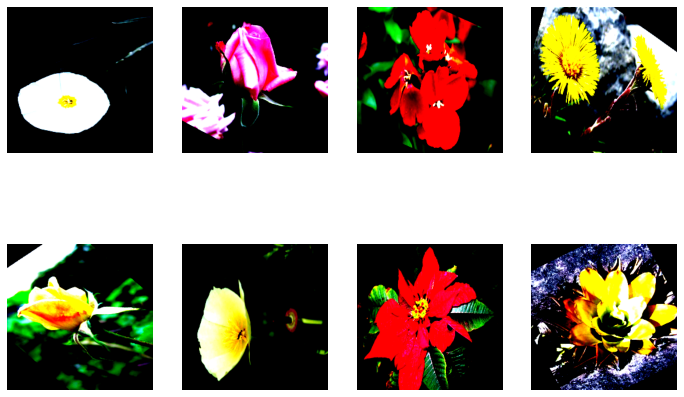

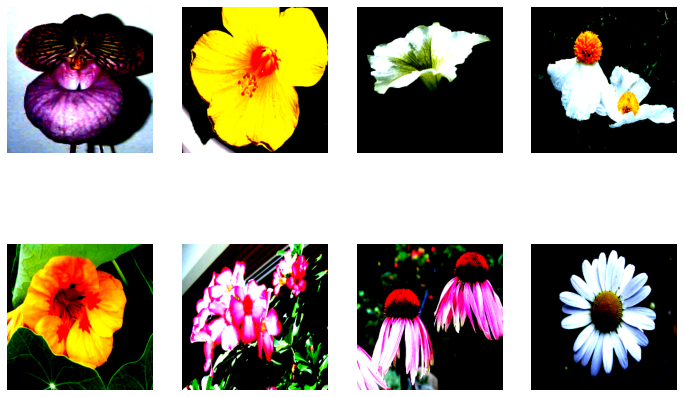

In [3]:
class FlowerDateset(Dataset):
    def __init__(self, metadata, transform=None):
        self.metadata = metadata
        self.transform = transform

    def __getitem__(self, index):
        image_path = self.metadata.iloc[index, 0]
        image = skio.imread("{}/{}".format(RAW_DATASET_IMAGES_FOLDER, image_path))
        label = torch.tensor(int(self.metadata.iloc[index, 1]))
        # label = F.one_hot(label, num_classes=102)
        # label = label.float()
        if self.transform:
            image = self.transform(image)

        return (image, label)

    def __len__(self):
        return len(self.metadata)


transform_train = transforms.Compose(
    [
        # transforms.ToPILImage(),
        transforms.RandomRotation(45),
        transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        # transforms.AutoAugment(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)
transform_valid = transforms.Compose(
    [
        # transforms.ToPILImage(),
        # transforms.RandomRotation(45),
        # transforms.RandomHorizontalFlip(),
        transforms.Resize((CROPPED_IMAGES_SIZE, CROPPED_IMAGES_SIZE)),
        # transforms.RandomCrop(CROPPED_IMAGES_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    ]
)


dataset_train = datasets.ImageFolder("data/images", transform=transform_train)
dataset_valid = datasets.ImageFolder("data/images", transform=transform_valid)
# dataset = FlowerDateset(metadata, transform=transform)

train_size = int(len(dataset_train) * DATASET_SPLIT)
validation_test_size = len(dataset_train) - train_size

indices = torch.randperm(len(dataset_train))
train_dataset = torch.utils.data.Subset(dataset_train, indices[:-validation_test_size])
validation_test_dataset = torch.utils.data.Subset(
    dataset_valid, indices[-validation_test_size:]
)

validation_size = int(len(validation_test_dataset) * TESTING_VALIDATION_SPLIT)
test_size = len(validation_test_dataset) - validation_size

indices = torch.randperm(len(validation_test_dataset))
validation_dataset = torch.utils.data.Subset(validation_test_dataset, indices[:-test_size])
test_dataset = torch.utils.data.Subset(validation_test_dataset, indices[-test_size:])


# train_dataset, validation_test_dataset = data.random_split(
#     dataset_train, [train_set_size, validation_set_size + test_set_size]
# )
# validation_dataset, test_dataset = data.random_split(
#     validation_test_dataset, [validation_set_size, test_set_size]
# )


# train_dataset = torch.utils.data.Subset(train_dataset, indices=torch.arange(train_set_size))
# validation_dataset = torch.utils.data.Subset(validation_dataset, indices=torch.arange(validation_set_size))
# test_dataset = torch.utils.data.Subset(test_dataset, indices=torch.arange(test_set_size))

# train_dataset.dataset.transform = transform_train
# validation_dataset.dataset.transform = transform_valid
# test_dataset.dataset.transform = transform_valid

train_dataloader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = data.DataLoader(
    validation_dataset, batch_size=BATCH_SIZE, shuffle=True
)
test_dataloader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

print("Train dataset size: {}".format(len(train_dataset)))
print("Validation dataset size: {}".format(len(validation_dataset)))
print("Test dataset size: {}".format(len(test_dataset)))

n_rows = 2
n_cols = 4

for x, y in train_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1, 2, 0))
            ax[i, j].axis("off")
            # ax[i, j].set_title(labelReference[label])
    break
n_rows = 2
n_cols = 4

for x, y in validation_dataloader:
    x = x.to(device)
    fig, ax = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(12, 8))
    for i in range(n_rows):
        for j in range(n_cols):
            ax[i, j].imshow(x[(i * n_cols) + j].cpu().permute(1, 2, 0))
            ax[i, j].axis("off")
            # ax[i, j].set_title(labelReference[label])
    break


## Creating the model

Here we create our CNN model with 2 simple layers or use the ResNet18 model.

We use a kernel_size=(3,3), stride=(1,1) and padding=(1,1) in order to have a same convolution (manteins image size).

We use a MaxPool2d to reduce the size of the network by half efficiently.

We use a Linear to create the last fully connected layer.  

We use the Adam optimizer and the CrossEntropyLoss as our loss function.


In [4]:
class My2LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My2LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 4) * int(img_height / 4) * num_out_channels[1],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.fc(x.reshape(x.shape[0], -1))
        return x
class My4LayerCNN(nn.Module):
    def __init__(
        self,
        num_in_channels=3,
        num_out_channels=HIDDEN_LAYERS_OUTPUT_CHANNELS,
        img_width=CROPPED_IMAGES_SIZE,
        img_height=CROPPED_IMAGES_SIZE,
        num_classes=102,
    ):
        super(My4LayerCNN, self).__init__()
        self.conv1 = nn.Conv2d(
            in_channels=num_in_channels,
            out_channels=num_out_channels[0],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv2 = nn.Conv2d(
            in_channels=num_out_channels[0],
            out_channels=num_out_channels[1],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv3 = nn.Conv2d(
            in_channels=num_out_channels[1],
            out_channels=num_out_channels[2],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.conv4 = nn.Conv2d(
            in_channels=num_out_channels[2],
            out_channels=num_out_channels[3],
            kernel_size=(3, 3),
            stride=(1, 1),
            padding=(1, 1),
        )
        self.pool = nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))
        self.fc = nn.Linear(
            in_features=int(img_width / 16) * int(img_height / 16) * num_out_channels[3],
            out_features=num_classes,
        )

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.fc(x.view(x.shape[0], -1))
        return x


# Load saved model
if CHOOSEN_MODEL == 0:
    model = My2LayerCNN()
    model.load_state_dict(torch.load('model.pt'))
    model.eval()
# My 2 Layer CNN model
if CHOOSEN_MODEL == 1:
    model = My2LayerCNN()
# Resnet
if CHOOSEN_MODEL == 2:
    model = My4LayerCNN()
# Resnet pretrained
if CHOOSEN_MODEL == 3:
    model = models.resnet18(weights=ResNet18_Weights.DEFAULT)
    model.fc = nn.Linear(model.fc.in_features, 102)


model = model.to(device)

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Loss function
criterion = nn.CrossEntropyLoss()


## Train model


In [5]:
training_results_data = pd.DataFrame(
    {"Epoch": [], "Predictions": [], "Samples": [], "Accuracy": [], "Loss": []}
)

def check_accuracy(data_loader, model):
    n_corrects = 0
    n_samples = 0
    model.eval()

    with torch.no_grad():
        for x, y in data_loader:
            # Sending data to device
            x = x.to(device)
            y = y.to(device)

            # Forward propagation
            y_hat = model(x)

            # Calculate accuracy
            _, predictions = y_hat.max(1)
            n_corrects += (predictions == y).sum()
            n_samples += predictions.size(0)

        perc = (n_corrects.item() / n_samples) * 100
        return (n_corrects.item(), n_samples, perc)


if CHOOSEN_MODEL != 0: 
    model.train()
    # Tensorboard writer
    writer = SummaryWriter()
    for epoch in range(N_EPOCHS):
        running_loss = 0.0

        with tqdm.tqdm(train_dataloader, unit="batch") as tepoch:

            for index, (x, y) in enumerate(tepoch):
        
                optimizer.zero_grad()
                # Send the data to the device
                x = x.to(device)
                y = y.to(device)

                # Forward propagation
                y_hat = model(x)
                loss = criterion(y_hat, y)
                running_loss += loss

                # Backward propagation
                # Calculate derivatives for every parameters
                loss.backward()
                # Do gradient descent
                optimizer.step()
                tepoch.set_postfix(loss=loss.item())

            print(f"Epoch {epoch + 1}, loss: {running_loss}")
            n_corrects, n_samples, accuracy = check_accuracy(validation_dataloader, model)
            print(f"Accuracy: {n_corrects}/{n_samples} = {accuracy:.2f}%")
            # writer.add_figure("Confusion matrix", createConfusionMatrix(validation_dataloader, model), epoch)
            training_results_data.loc[len(training_results_data.index)] = [
                int(epoch + 1),
                int(n_corrects),
                int(n_samples),
                accuracy,
                running_loss.item(),
            ]
            writer.add_scalar("Loss/train", running_loss, epoch)
            writer.add_scalar('Accuracy/validation', accuracy, epoch)


    writer.flush()

    

    # Saving model
    torch.save(model.state_dict(), 'model.pt')

# Saving parameters
with open('model_parameters.txt', 'w') as file:
    file.write(f"CHOOSEN_MODEL = {CHOOSEN_MODEL}\n")
    file.write(f"SEED = {SEED}\n")
    file.write(f"DATASET_SPLIT = {DATASET_SPLIT}\n")
    file.write(f"TESTING_VALIDATION_SPLIT = {TESTING_VALIDATION_SPLIT}\n")
    file.write(f"BATCH_SIZE = {BATCH_SIZE}\n")
    file.write(f"N_EPOCHS = {N_EPOCHS}\n")
    file.write(f"HIDDEN_LAYERS_OUTPUT_CHANNELS = {HIDDEN_LAYERS_OUTPUT_CHANNELS}\n")
    file.write(f"CROPPED_IMAGES_SIZE = {CROPPED_IMAGES_SIZE}\n")
    file.write(f"LEARNING_RATE = {LEARNING_RATE}\n")

100%|██████████| 116/116 [02:42<00:00,  1.40s/batch, loss=2.5] 


Epoch 1, loss: 459.9693908691406
Accuracy: 49/163 = 30.06%


100%|██████████| 116/116 [01:58<00:00,  1.02s/batch, loss=2.44]


Epoch 2, loss: 298.06610107421875
Accuracy: 63/163 = 38.65%


100%|██████████| 116/116 [01:54<00:00,  1.01batch/s, loss=2.13]


Epoch 3, loss: 252.3059539794922
Accuracy: 72/163 = 44.17%


100%|██████████| 116/116 [01:55<00:00,  1.00batch/s, loss=3.21]


Epoch 4, loss: 220.16490173339844
Accuracy: 80/163 = 49.08%


100%|██████████| 116/116 [02:01<00:00,  1.05s/batch, loss=2.55]


Epoch 5, loss: 200.1634979248047
Accuracy: 84/163 = 51.53%


100%|██████████| 116/116 [02:45<00:00,  1.42s/batch, loss=1.7] 


Epoch 6, loss: 180.177490234375
Accuracy: 80/163 = 49.08%


100%|██████████| 116/116 [02:43<00:00,  1.41s/batch, loss=1]    


Epoch 7, loss: 165.80577087402344
Accuracy: 89/163 = 54.60%


100%|██████████| 116/116 [02:24<00:00,  1.25s/batch, loss=2.79]


Epoch 8, loss: 153.69911193847656
Accuracy: 91/163 = 55.83%


100%|██████████| 116/116 [02:22<00:00,  1.23s/batch, loss=0.808]


Epoch 9, loss: 139.23187255859375
Accuracy: 89/163 = 54.60%


100%|██████████| 116/116 [02:11<00:00,  1.13s/batch, loss=1.58] 


Epoch 10, loss: 134.93165588378906
Accuracy: 90/163 = 55.21%


100%|██████████| 116/116 [02:06<00:00,  1.09s/batch, loss=0.717]


Epoch 11, loss: 127.30939483642578
Accuracy: 98/163 = 60.12%


100%|██████████| 116/116 [01:58<00:00,  1.02s/batch, loss=1.03] 


Epoch 12, loss: 118.08814239501953
Accuracy: 91/163 = 55.83%


100%|██████████| 116/116 [02:07<00:00,  1.10s/batch, loss=1.44] 


Epoch 13, loss: 114.4058837890625
Accuracy: 95/163 = 58.28%


100%|██████████| 116/116 [02:18<00:00,  1.19s/batch, loss=1.85] 


Epoch 14, loss: 109.6242446899414
Accuracy: 88/163 = 53.99%


100%|██████████| 116/116 [02:01<00:00,  1.05s/batch, loss=1.02] 


Epoch 15, loss: 107.4228286743164
Accuracy: 93/163 = 57.06%


100%|██████████| 116/116 [02:03<00:00,  1.06s/batch, loss=1.98] 


Epoch 16, loss: 98.50402069091797
Accuracy: 90/163 = 55.21%


100%|██████████| 116/116 [02:24<00:00,  1.24s/batch, loss=0.758]


Epoch 17, loss: 94.40382385253906
Accuracy: 92/163 = 56.44%


100%|██████████| 116/116 [02:02<00:00,  1.06s/batch, loss=0.981]


Epoch 18, loss: 89.72372436523438
Accuracy: 91/163 = 55.83%


100%|██████████| 116/116 [02:09<00:00,  1.11s/batch, loss=0.127]


Epoch 19, loss: 86.63948822021484
Accuracy: 91/163 = 55.83%


100%|██████████| 116/116 [02:00<00:00,  1.04s/batch, loss=0.55] 


Epoch 20, loss: 82.34577941894531
Accuracy: 98/163 = 60.12%


## Results

Training/Validation results
╒═════════╤═══════════════════════╤════════════╤══════════╕
│   Epoch │ Predictions/Samples   │ Accuracy   │     Loss │
╞═════════╪═══════════════════════╪════════════╪══════════╡
│       1 │ 49/163                │ 30.06%     │ 459.969  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       2 │ 63/163                │ 38.65%     │ 298.066  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       3 │ 72/163                │ 44.17%     │ 252.306  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       4 │ 80/163                │ 49.08%     │ 220.165  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       5 │ 84/163                │ 51.53%     │ 200.163  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       6 │ 80/163                │ 49.08%     │ 180.177  │
├─────────┼───────────────────────┼────────────┼──────────┤
│       7 │ 89/163                │ 54.60%     │ 165.806  │
├─────────┼─

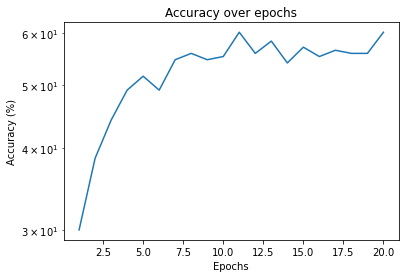

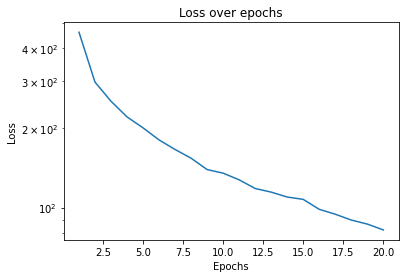

Testing results
Testing accuracy: 374/656 (57.01%)


In [7]:
def createConfusionMatrix(data_loader, model):
    confusion_matrix = torch.zeros((102, 102))
    with torch.no_grad():
        for i, (inputs, classes) in enumerate(data_loader):
            inputs = inputs.to(device)
            classes = classes.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            for t, p in zip(classes.view(-1), preds.view(-1)):
                    confusion_matrix[t.long(), p.long()] += 1

    fig = plt.figure(figsize=(250,250))

    # confusion_matrix_np = confusion_matrix.numpy()
    # np.savetxt("confusion_matrix.csv", confusion_matrix_np, delimiter=",")
    
    class_names = list(labelReference.values())
    df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
    df_cm.to_csv('confusion_matrix.csv')

    heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig
# def createConfusionMatrix(data_loader, model):
#     confusion_matrix = np.zeros((102, 102))
#     with torch.no_grad():
#         for i, (inputs, classes) in enumerate(data_loader):
#             inputs = inputs.to(device)
#             classes = classes.to(device)
#             outputs = model(inputs)
#             _, preds = torch.max(outputs, 1)
#             print(preds)
#             for t, p in zip(classes.view(-1), preds.view(-1)):
#                     confusion_matrix[t.long(), p.long()] += 1

#     # fig = plt.figure(figsize=(250,250))

#     class_names = list(labelReference.values())
#     df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names).astype(int)
#     df_cm.to_csv('confusion_matrix.csv')
#     # heatmap = sn.heatmap(df_cm, annot=True, fmt="d")

#     # heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right',fontsize=10)
#     # heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right',fontsize=10)
#     # plt.ylabel('True label')
#     # plt.xlabel('Predicted label')
#     # return fig

if CHOOSEN_MODEL != 0:
    print("Training/Validation results")
    formatted_training_results_data = pd.DataFrame(
        {"Epoch": [], "Predictions/Samples": [], "Accuracy": [], "Loss": []}
    )
    for index, row in training_results_data.iterrows():
        formatted_training_results_data.loc[len(formatted_training_results_data.index)] = [
                row[0],
                f"{int(row[1])}/{int(row[2])}",
                f"{row[3]:.2f}%",
                f"{row[4]}",
            ]

    print(tabulate(formatted_training_results_data, headers = 'keys', tablefmt = 'fancy_grid', showindex="never"))

    plt.plot(training_results_data["Epoch"], training_results_data["Accuracy"])
    plt.title('Accuracy over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.yscale('log')
    # plt.grid(True)
    plt.show()

    plt.plot(training_results_data["Epoch"], training_results_data["Loss"])
    plt.title('Loss over epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.yscale('log')
    # plt.grid(True)
    plt.show()

print("Testing results")
n_corrects, n_samples, accuracy = check_accuracy(test_dataloader, model)
print(f"Testing accuracy: {n_corrects}/{n_samples} ({accuracy:.2f}%)")
# writer.add_figure("Confusion matrix", createConfusionMatrix(test_dataloader, model))
# writer.flush()
# writer.close()
createConfusionMatrix(test_dataloader, model)